<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Project <br>
<font color=696880 size=4>
    Project Team 
    
    
____


### Full Name : Mohammad Bagher Soltani, Seyed Mohammad Yousef Najafi
### Student Number : 98105813, 99102361
___

# Introduction

In this project, we are going to have a brief and elementary hands-on real-world project, predicting breast cancer survival using machine learning models with clinical data and gene expression profiles.

In [50]:
# imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.std import tqdm
from torch.optim import Adam
from copy import deepcopy

In [51]:
SEED = 99

In [52]:
np.random.seed(SEED)

# Data Documentation

For this purpose, we will use "Breast Cancer Gene Expression Profiles (METABRIC)" data. 
The first 31 columns of data contain clinical information including death status.
The next columns of the data contain gene's related information which includes both gene expressions and mutation information. (gene's mutation info columns have been marked with "_mut" at the end of the names of the columns) 
For more information please read the [data documentation](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric).

# Data Preparation (15 Points)

In this section you must first split data into three datasets:
<br>
1- clinical dataset
<br>
2- gene expressions dataset
<br>
3- gene mutation dataset. (We will not use this dataset in further steps of the project)

## Data Loading & Splitting

In [53]:
# TODO
df = pd.read_csv('METABRIC_RNA_Mutation.csv', low_memory=False)
df.head(5)

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# Get column names for clinical, gene expression and gene mutation datasets

columns = df.columns
clinical_columns = columns[:31]
clinical_data_columns = df.columns[:24].append(df.columns[25:30])
label_column = columns[24]
gene_columns = columns[31:]
gene_mut_columns = pd.Index(filter(lambda s: s.endswith('_mut'),columns))
gene_expr_columns = pd.Index(set(gene_columns) - set(gene_mut_columns))

print(f'Number of clinical columns {len(clinical_columns)}')
print(f'Number of gene expression columns {len(gene_expr_columns)}')
print(f'Number of gene mutation columns {len(gene_mut_columns)}')

Number of clinical columns 31
Number of gene expression columns 489
Number of gene mutation columns 173


In [55]:
clinical_dataset = df[clinical_columns]
gene_expr_dataset = df[gene_expr_columns]
gene_mut_dataset = df[gene_mut_columns]

## EDA

For each dataset, you must perform a sufficient EDA.

In [56]:
clinical_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      1904 non-null   int64  
 1   age_at_diagnosis                1904 non-null   float64
 2   type_of_breast_surgery          1882 non-null   object 
 3   cancer_type                     1904 non-null   object 
 4   cancer_type_detailed            1889 non-null   object 
 5   cellularity                     1850 non-null   object 
 6   chemotherapy                    1904 non-null   int64  
 7   pam50_+_claudin-low_subtype     1904 non-null   object 
 8   cohort                          1904 non-null   float64
 9   er_status_measured_by_ihc       1874 non-null   object 
 10  er_status                       1904 non-null   object 
 11  neoplasm_histologic_grade       1832 non-null   float64
 12  her2_status_measured_by_snp6    19

In [57]:
clinical_dataset.describe()

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage
count,1904.000000,1904.000000,1904.000000,1904.000000,1832.000000,1904.000000,1904.000000,1859.000000,1904.000000,1904.000000,1904.000000,1904.000000,1884.000000,1403.000000
mean,3921.982143,61.087054,0.207983,2.643908,2.415939,0.616597,2.002101,5.697687,4.033019,125.121324,0.420693,0.597164,26.238726,1.750535
std,2358.478332,12.978711,0.405971,1.228615,0.650612,0.486343,4.079993,4.058778,1.144492,76.334148,0.493800,0.490597,15.160976,0.628999
min,0.000000,21.930000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,896.500000,51.375000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.046000,60.825000,0.000000,0.000000,17.000000,1.000000
50%,4730.500000,61.770000,0.000000,3.000000,3.000000,1.000000,0.000000,5.000000,4.042000,115.616667,0.000000,1.000000,23.000000,2.000000
75%,5536.250000,70.592500,0.000000,3.000000,3.000000,1.000000,2.000000,7.000000,5.040250,184.716667,1.000000,1.000000,30.000000,2.000000
max,7299.000000,96.290000,1.000000,5.000000,3.000000,1.000000,45.000000,80.000000,6.360000,355.200000,1.000000,1.000000,182.000000,4.000000


In [58]:
gene_expr_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 489 entries, npnt to cyp3a4
dtypes: float64(489)
memory usage: 7.1 MB


In [59]:
gene_expr_dataset.describe()

,npnt,ccne1,st7,eif4ebp1,srd5a2,pde4dip,bmpr2,mmp12,lfng,mapk7,...,rbpj,nfkb2,taf1,ldlrap1,cul1,fam20c,bbc3,serpini1,cdk8,cyp3a4
count,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,...,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03
mean,0.000001,-5.252101e-08,-1.050420e-07,-4.201681e-07,-3.676471e-07,-7.352941e-07,-5.252101e-08,-8.928571e-07,1.050420e-07,-2.100840e-07,...,-4.726891e-07,0.000002,1.050420e-07,-7.463684e-18,6.302521e-07,-0.000001,0.000001,4.201681e-07,-4.201681e-07,-8.403361e-07
std,1.000262,1.000263e+00,1.000263e+00,1.000263e+00,1.000262e+00,1.000263e+00,1.000262e+00,1.000263e+00,1.000262e+00,1.000262e+00,...,1.000263e+00,1.000263,1.000263e+00,1.000262e+00,1.000262e+00,1.000263,1.000262,1.000263e+00,1.000262e+00,1.000263e+00
min,-2.121900,-1.547000e+00,-4.982700e+00,-1.811200e+00,-3.364800e+00,-2.534200e+00,-4.831100e+00,-1.098200e+00,-2.971100e+00,-2.924100e+00,...,-2.850200e+00,-2.493500,-3.228700e+00,-2.675800e+00,-3.179400e+00,-2.929400,-3.363800,-1.568800e+00,-2.845000e+00,-3.114400e+00
25%,-0.806875,-6.786000e-01,-6.136750e-01,-6.632500e-01,-6.104750e-01,-6.643750e-01,-6.325500e-01,-6.131250e-01,-6.866750e-01,-6.466250e-01,...,-7.010750e-01,-0.660650,-6.443000e-01,-6.824500e-01,-6.318000e-01,-0.659075,-0.668900,-6.591000e-01,-6.620000e-01,-6.733000e-01
50%,-0.025150,-2.812000e-01,-5.175000e-02,-2.543500e-01,-4.690000e-02,-9.090000e-02,1.650000e-03,-4.098000e-01,-2.270000e-02,-6.985000e-02,...,-4.375000e-02,-0.126900,2.640000e-02,-9.905000e-02,-6.660000e-02,0.000750,-0.024800,-2.632000e-01,-8.260000e-02,-2.150000e-02
75%,0.707550,3.701250e-01,5.787750e-01,3.648500e-01,5.144500e-01,5.494000e-01,6.422500e-01,2.039000e-01,6.734000e-01,5.482500e-01,...,6.351250e-01,0.453700,6.409000e-01,5.876750e-01,4.961000e-01,0.639675,0.621100,3.232500e-01,5.667000e-01,6.230500e-01
max,4.022300,5.644100e+00,4.571300e+00,7.403600e+00,1.027030e+01,9.131400e+00,3.054200e+00,5.978200e+00,3.107200e+00,6.626600e+00,...,3.512400e+00,5.892300,3.733000e+00,5.485100e+00,5.621200e+00,4.078000,3.762400,5.286100e+00,4.772000e+00,4.369500e+00


In [60]:
gene_mut_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 173 entries, pik3ca_mut to siah1_mut
dtypes: object(173)
memory usage: 2.5+ MB


In [61]:
gene_mut_dataset.describe()


,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
count,1904,1904,1904,1904,1904,1904,1904,1904,1904,1904,...,1904,1904,1904,1904,1904,1904,1904,1904,1904,1904
unique,160,343,298,248,222,200,128,194,153,154,...,5,5,5,4,4,3,3,3,3,2
top,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,1109,1245,1578,1593,1670,1672,1674,1706,1728,1729,...,1900,1900,1900,1901,1901,1902,1902,1902,1902,1903


In [62]:
# clean data means data with no NaN value in any column
def clean_stats(ds):
    return '''clean data: {0}'''.format(ds.shape[0] - ds.isnull().any(axis=1).sum())

print(f'Clinical dataset {clean_stats(clinical_dataset)}')
print(f'Gene expression dataset {clean_stats(gene_expr_dataset)}')
print(f'Gene mutation dataset {clean_stats(gene_mut_dataset)}')

Clinical dataset clean data: 1092
Gene expression dataset clean data: 1904
Gene mutation dataset clean data: 1904


In [63]:
clinical_dataset.dtypes

patient_id                          int64
age_at_diagnosis                  float64
type_of_breast_surgery             object
cancer_type                        object
cancer_type_detailed               object
cellularity                        object
chemotherapy                        int64
pam50_+_claudin-low_subtype        object
cohort                            float64
er_status_measured_by_ihc          object
er_status                          object
neoplasm_histologic_grade         float64
her2_status_measured_by_snp6       object
her2_status                        object
tumor_other_histologic_subtype     object
hormone_therapy                     int64
inferred_menopausal_state          object
integrative_cluster                object
primary_tumor_laterality           object
lymph_nodes_examined_positive     float64
mutation_count                    float64
nottingham_prognostic_index       float64
oncotree_code                      object
overall_survival_months           

In [64]:
def dtype_stats(ds):
    return '''
    columns: {0}, object columns: {1}, int columns: {2}, float columns: {3}
    '''.format(len(ds.columns),
               (ds.dtypes == 'object').sum(),
               (ds.dtypes == 'int64').sum(),
               (ds.dtypes == 'float64').sum())

print(f'Clinical dataset: {dtype_stats(clinical_dataset)}')
print(f'Gene expression dataset: {dtype_stats(gene_expr_dataset)}')
print(f'Gene mutation dataset: {dtype_stats(gene_mut_dataset)}')

Clinical dataset: 
    columns: 31, object columns: 17, int columns: 5, float columns: 9
    
Gene expression dataset: 
    columns: 489, object columns: 0, int columns: 0, float columns: 489
    
Gene mutation dataset: 
    columns: 173, object columns: 173, int columns: 0, float columns: 0
    


In [65]:
# check if int data needs scaling
clinical_dataset[clinical_columns[clinical_dataset.dtypes == 'int64']].head(5)

,patient_id,chemotherapy,hormone_therapy,overall_survival,radio_therapy
0,0,0,1,1,1
1,2,0,1,1,1
2,5,1,1,0,0
3,6,1,1,1,1
4,8,1,1,0,1


In [66]:
# define data and labels for each dataset

labels = clinical_dataset[label_column].to_numpy()
clinical_data = clinical_dataset[clinical_data_columns].to_numpy()
gene_expr_data = gene_expr_dataset.to_numpy()

In [67]:
# Convert categorical data to numerical data for clinical dataset
ordinal_encoder = OrdinalEncoder()
clinical_data = ordinal_encoder.fit_transform(clinical_data)

In [68]:
# Perform data imputation for clinical dataset
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
clinical_data = imputer.fit_transform(clinical_data)

In [69]:
scaler = StandardScaler()
clinical_data = scaler.fit_transform(clinical_data)


In [70]:
_clinical_train_X, _clinical_test_X, _clinical_train_y, _clinical_test_y = train_test_split(clinical_data, labels, test_size=0.10, random_state=SEED)
_clinical_train_X, _clinical_val_X, _clinical_train_y, _clinical_val_y = train_test_split(_clinical_train_X, _clinical_train_y, test_size=0.10, random_state=SEED)

_gene_expr_train_X, _gene_expr_test_X, _gene_expr_train_y, _gene_expr_test_y = train_test_split(gene_expr_data, labels, test_size=0.10, random_state=SEED)
_gene_expr_train_X, _gene_expr_val_X, _gene_expr_train_y, _gene_expr_val_y = train_test_split(_gene_expr_train_X, _gene_expr_train_y, test_size=0.10, random_state=SEED)

dataset = {
    'clinical':{
        'X_train': _clinical_train_X,
        'X_val': _clinical_val_X,
        'X_test': _clinical_test_X,
        'y_train': _clinical_train_y,
        'y_val': _clinical_val_y,
        'y_test': _clinical_test_y
    },
    'gene_expr':{
        'X_train': _gene_expr_train_X,
        'X_val': _gene_expr_val_X,
        'X_test': _gene_expr_test_X,
        'y_train': _gene_expr_train_y,
        'y_val': _gene_expr_val_y,
        'y_test': _gene_expr_test_y
    },
    'gene_expr_reduced':{
    }
}

(29, 29)


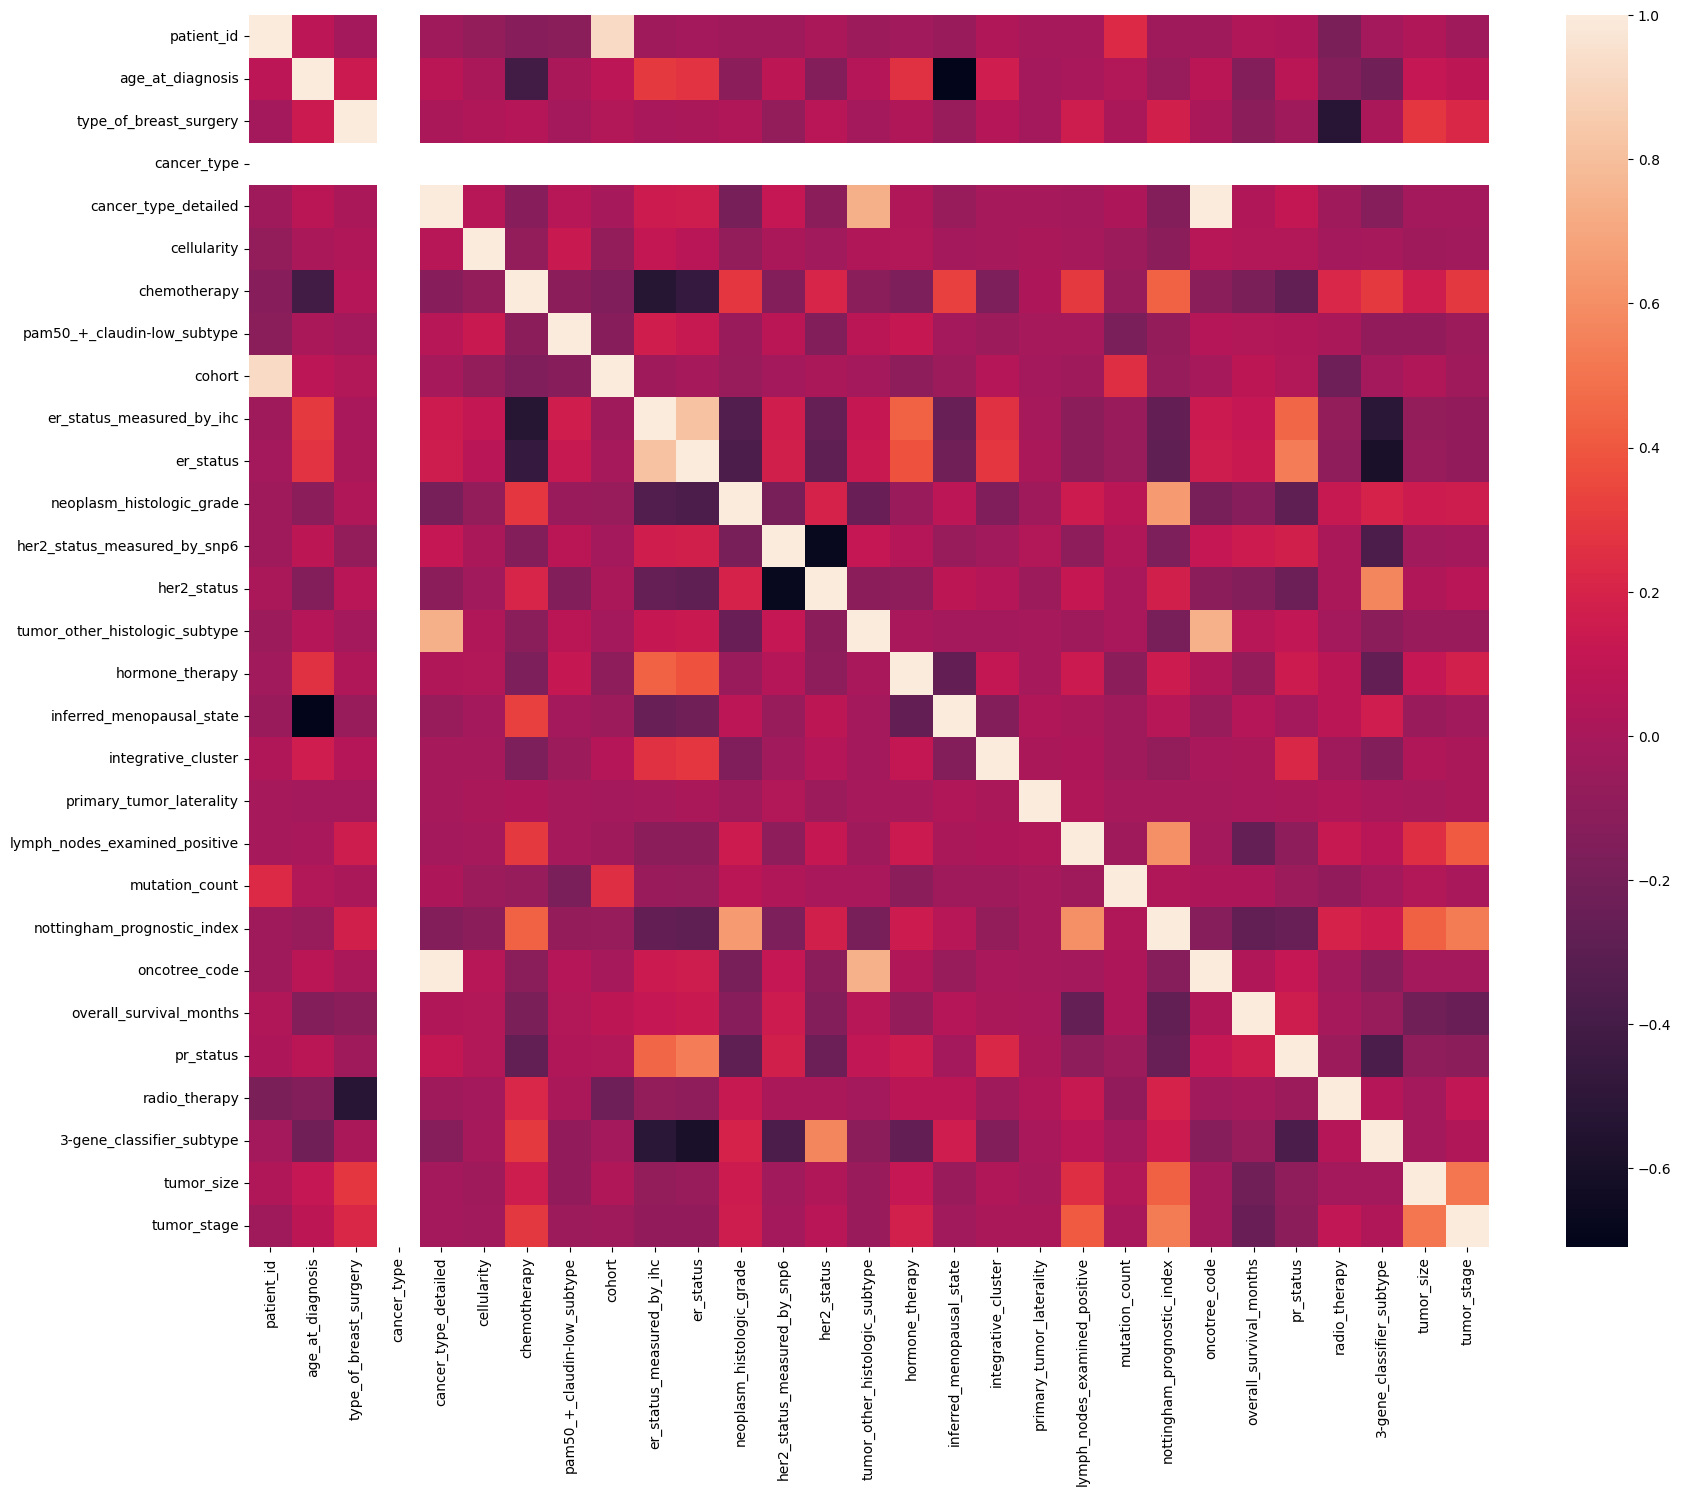

In [71]:
df=pd.DataFrame(dataset['clinical']['X_train'])
df.columns=clinical_data_columns
correlation = df.corr()
plt.figure(figsize=(20, 16))
print(correlation.shape)
sns.heatmap(correlation, fmt=".1g")
plt.show()

(array([1103.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         801.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

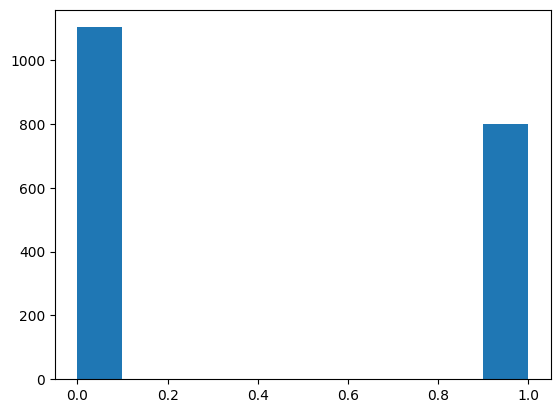

In [72]:
#plot histogram of labels
plt.hist(labels)

(array([911.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 630.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

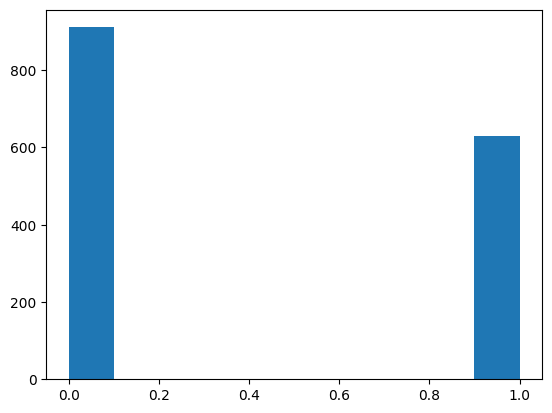

In [73]:
#plot histogram 
plt.hist(dataset['clinical']['y_train'])

(array([911.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 630.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

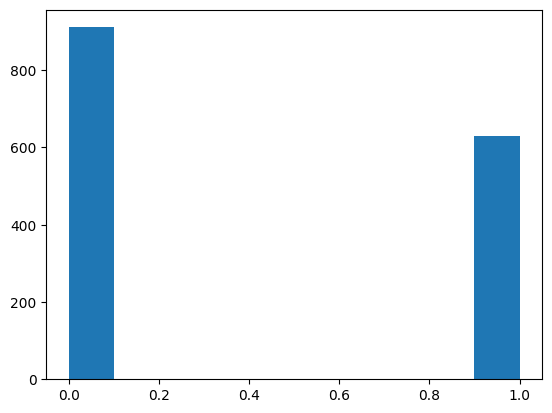

In [74]:
#plot histogram 
plt.hist(dataset["gene_expr"]['y_train'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f93c754de80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f93c7313880>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f93c754d5b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f93cbb224c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f93cbaefdc0>],
 'means': []}

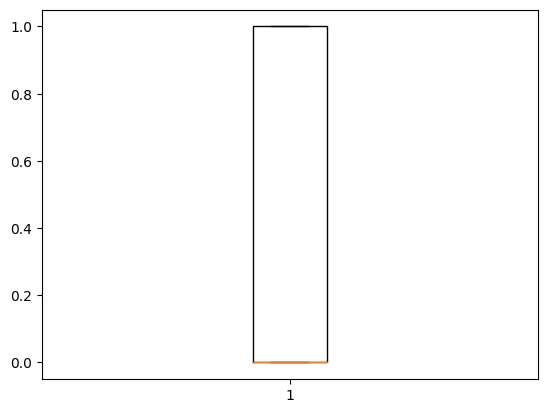

In [75]:
#plot boxplot of labels
plt.boxplot(labels)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f93cbc8c7c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f93cbb3dd60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f93cbc8c190>],
 'medians': [<matplotlib.lines.Line2D at 0x7f93cbb3d520>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f93cbb3dfd0>],
 'means': []}

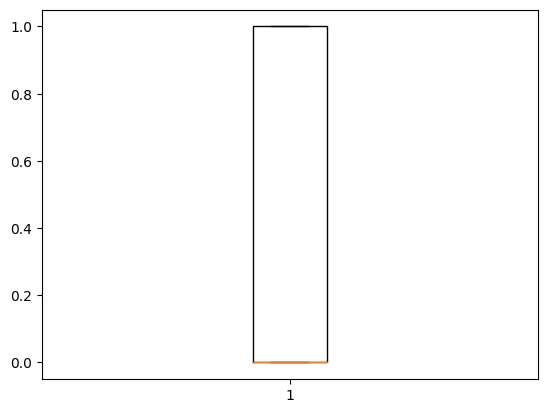

In [76]:
plt.boxplot(dataset['clinical']['y_train'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7f93c7650b20>,
 'caps': [<matplotlib.lines.Line2D at 0x7f93c76503a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f93c7596940>],
 'medians': [<matplotlib.lines.Line2D at 0x7f93c75931c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f93c7593880>],
 'means': []}

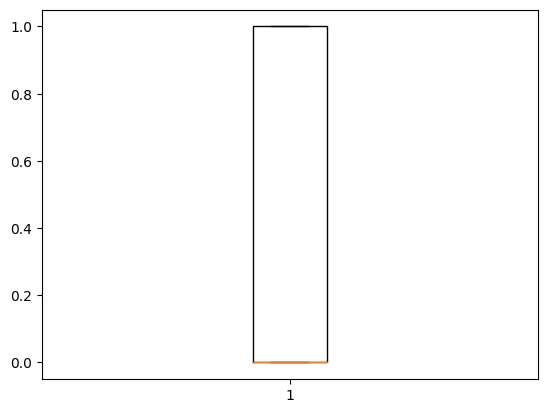

In [77]:
plt.boxplot(dataset['gene_expr']['y_train'])


## Dimension Reduction (20 + Up to 10 Points Optional)

For each dataset, investigate whether it is needed to use a dimensionality reduction approach or not. If yes, please reduce the dataset's dimension. You can use UMAP for this purpose but any other approach is acceptable. Finding the most important features contains extra points.

<span style="color:orange">
    we check if dimensionality reduction is needed by using a simple linear regression model as a baseline .
</span>



In [78]:
# predict for the clinical dataset using linear regression
_clf = LinearRegression()
_clf.fit(dataset['clinical']['X_train'], dataset['clinical']['y_train'])
_clinical_baseline_pred = np.round(_clf.predict(dataset['clinical']['X_test']))
_clinical_baseline_accuracy = accuracy_score(dataset['clinical']['y_test'], _clinical_baseline_pred)

# predict for the gene expression dataset using linear regression
_clf = LinearRegression()
_clf.fit(dataset['gene_expr']['X_train'], dataset['gene_expr']['y_train'])
_gene_expr_baseline_pred = np.round(_clf.predict(dataset['gene_expr']['X_test']))
_gene_expr_baseline_accuracy = accuracy_score(dataset['gene_expr']['y_test'], _gene_expr_baseline_pred)

print(f'Accuracy of simple linear regression model on clinical data: {_clinical_baseline_accuracy:.3f}')
print(f'Accuracy of simple linear regression model on gene expression data: {_gene_expr_baseline_accuracy:.3f}')

Accuracy of simple linear regression model on clinical data: 0.723
Accuracy of simple linear regression model on gene expression data: 0.618


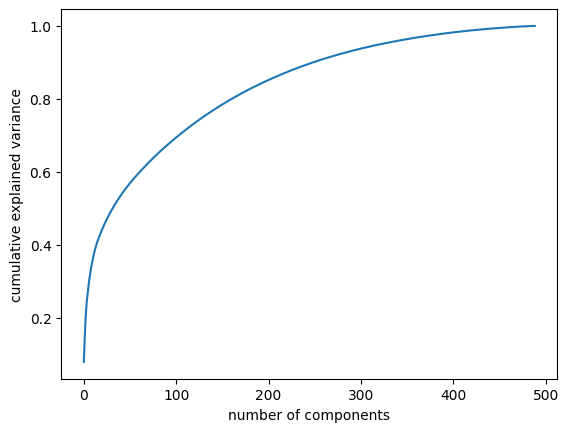

In [79]:
# find the best number of components for PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = gene_expr_data.shape[1])

pca_components = pca.fit_transform(gene_expr_data)

#plot pca.explained_variance_ratio_ 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


Explained variance ratio is a metric of how important input features are. The higher the explained variance is, the more importance the feature has.
Having the plot of cumulative explained variance based on number of components gives us a view and control over how much we want to keep the original data information and how much we want the dimensionality to reduce.

Feature Selection

In [80]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
df=pd.DataFrame(dataset['gene_expr']['X_train'])
df.columns=gene_expr_dataset.columns
print(df.columns)
X=df
Y=pd.DataFrame(dataset['gene_expr']['y_train'])
#f_classif returns the ANOVA F-value and p-value for each feature in the dataset so we can decide which 
# features are the most important ones
test = SelectKBest(score_func=f_classif, k=30)

fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
 




Index(['npnt', 'ccne1', 'st7', 'eif4ebp1', 'srd5a2', 'pde4dip', 'bmpr2',
       'mmp12', 'lfng', 'mapk7',
       ...
       'rbpj', 'nfkb2', 'taf1', 'ldlrap1', 'cul1', 'fam20c', 'bbc3',
       'serpini1', 'cdk8', 'cyp3a4'],
      dtype='object', length=489)
[1.660e+01 7.090e-02 1.363e+00 4.614e+00 6.404e-01 6.866e-01 7.616e+00
 2.972e+00 1.521e+01 1.095e+01 1.261e-01 3.690e+00 1.182e+01 3.984e-01
 7.413e-01 2.284e+00 8.373e+00 1.222e+00 1.674e+01 8.071e+00 7.773e-02
 3.961e+00 3.891e-01 1.933e-01 8.422e+00 1.962e-01 8.813e-01 2.158e+00
 7.309e-01 6.168e+00 1.763e+01 8.750e-01 7.963e+00 1.402e+01 2.336e-04
 4.785e-02 1.476e+01 1.280e+01 4.511e+01 8.978e+00 1.320e+01 1.618e+01
 6.960e+00 1.794e+00 2.107e+00 2.676e+00 2.643e+01 1.230e+00 2.007e+00
 3.024e+00 3.541e+00 1.972e+01 3.469e+00 3.904e+01 8.657e+00 4.657e+00
 1.416e+01 8.909e+00 4.456e+00 8.905e+00 4.190e-03 8.116e-01 1.884e+01
 9.477e-01 2.957e+01 6.236e+00 4.484e+00 4.645e+00 1.758e+00 2.734e+00
 1.049e+00 2.100e-01 3.647e+00 7

/media/soltani/sdb3/Documents/University/Term7/ML/Project/Practical/ml-final-project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [81]:
tmp=[]
for i in range(len(fit.scores_)):
    tmp.append((fit.scores_[i],gene_expr_columns[i]))

top_gene_expressions=sorted(tmp,key=lambda x: x[0], reverse=True)[:30]




gene_expr_selected=[x[1] for x in top_gene_expressions]

print(gene_expr_selected)




['hsd17b11', 'spry2', 'cdkn2c', 'jak1', 'gsk3b', 'kmt2c', 'casp8', 'pdgfra', 'tnk2', 'kit', 'map4', 'tsc2', 'smad4', 'abcb1', 'myc', 'lama2', 'fas', 'igf1', 'jak2', 'stat5a', 'rheb', 'tgfbr2', 'bap1', 'rps6', 'pdgfb', 'ar', 'ccnd2', 'sdc4', 'akt1', 'wwox']


So the most important features are tumor_stage and tumor_size because they have the most p-values. And if we train the model by them it will get the highest accuracy possible between different pairs of features.

<span style="color:orange">
    As we can see, the results are much better for the clinical dataset which has few dimensions, but not so much for the gene expession dataset.
    Therefore, we will only reduce the dimensions for gene expression dataset.
</span>



In [82]:
# reduce the dimensions for clinical data and predict using baseline model
CLINICAL_REDUCED_DIMENSIONS = 10
GENE_EXPR_REDUCED_DIMENSIONS = 30


_reducer = umap.UMAP(n_components=CLINICAL_REDUCED_DIMENSIONS, random_state=SEED)
_reducer.fit(clinical_data)
_reduced_X_train = _reducer.transform(dataset['clinical']['X_train'])
_reduced_X_test = _reducer.transform(dataset['clinical']['X_test'])

_clf = LinearRegression()
_clf.fit(_reduced_X_train, dataset['clinical']['y_train'])
_clinical_reduced_baseline_pred = np.round(_clf.predict(_reduced_X_test))
_clinical_reduced_baseline_accuracy = accuracy_score(dataset['clinical']['y_test'], _clinical_reduced_baseline_pred)

# reduce the dimensions for gene expression data and predict using baseline model
_reducer = umap.UMAP(n_components=GENE_EXPR_REDUCED_DIMENSIONS, random_state=SEED)
_reducer.fit(gene_expr_data)
_reduced_X_train = _reducer.transform(dataset['gene_expr']['X_train'])
_reduced_X_val = _reducer.transform(dataset['gene_expr']['X_val'])
_reduced_X_test = _reducer.transform(dataset['gene_expr']['X_test'])

_clf = LinearRegression()
_clf.fit(_reduced_X_train, dataset['gene_expr']['y_train'])
_gene_expr_reduced_baseline_pred = np.round(_clf.predict(_reduced_X_test))
_gene_expr_reduced_baseline_accuracy = accuracy_score(dataset['gene_expr']['y_test'], _gene_expr_reduced_baseline_pred)

print(f'Accuracy of simple linear regression model on reduced clinical data: {_clinical_reduced_baseline_accuracy:.3f}')
print(f'Accuracy of simple linear regression model on reduced gene expression data: {_gene_expr_reduced_baseline_accuracy:.3f}')


Accuracy of simple linear regression model on reduced clinical data: 0.576
Accuracy of simple linear regression model on reduced gene expression data: 0.649


In [83]:
gene_expr_selected_data = gene_expr_dataset[gene_expr_selected].to_numpy()

_gene_expr_selected_train_X, _gene_expr_selected_test_X, _gene_expr_selected_train_y, _gene_expr_selected_test_y = train_test_split(gene_expr_selected_data, labels, test_size=0.10, random_state=SEED)
_gene_expr_selected_train_X, _gene_expr_selected_val_X, _gene_expr_selected_train_y, _gene_expr_selected_val_y = train_test_split(_gene_expr_selected_train_X, _gene_expr_selected_train_y, test_size=0.10, random_state=SEED)

dataset['gene_expr_selected'] = {}
dataset['gene_expr_selected']['X_train'] = _gene_expr_selected_train_X
dataset['gene_expr_selected']['X_val'] = _gene_expr_selected_val_X
dataset['gene_expr_selected']['X_test'] = _gene_expr_selected_test_X
dataset['gene_expr_selected']['y_train'] = _gene_expr_selected_train_y
dataset['gene_expr_selected']['y_val'] = _gene_expr_selected_val_y
dataset['gene_expr_selected']['y_test'] = _gene_expr_selected_test_y


<span style="color:orange">
    As we can see, applying dimension reduction on the clinical dataset leads to worse results, while on gene expression dataset improves the predictions.
    Therefore, we choose to reduce the dimensions of only the gene expression dataset. 
</span>



In [84]:
dataset['gene_expr_reduced'] = {
    'X_train': _reduced_X_train,
    'X_val': _reduced_X_val,
    'X_test': _reduced_X_test,
    'y_train': _gene_expr_train_y,
    'y_val': _gene_expr_val_y,
    'y_test': _gene_expr_test_y
}

# Classic Model (25 Points)

In this section, you must implement a classic classification model for clinical, gene expressions, and reduced gene expressions datasets. Using Random Forest is suggested. (minimum acceptable accuracy = 60%)

In [85]:
random_forst_models = {
    'clinical': None,
    'gene_expr': None,
    'gene_expr_reduced': None,
    'gene_expr_selected': None
}

for ds_name in random_forst_models:
    clf = RandomForestClassifier(random_state=SEED)
    ds = dataset[ds_name]
    clf.fit(ds['X_train'], ds['y_train'])
    y_pred = clf.predict(ds['X_test'])
    acc = accuracy_score(ds['y_test'], y_pred)
    random_forst_models[ds_name] = {
        'model': clf,
        'accuracy': acc
    }

    print(f'random forest on {ds_name} dataset had accuracy of {acc:.4f}')

svm_models = random_forst_models.copy()

for ds_name in random_forst_models:
    clf = SVC(random_state=SEED)
    ds = dataset[ds_name]
    clf.fit(ds['X_train'], ds['y_train'])
    y_pred = clf.predict(ds['X_test'])
    acc = accuracy_score(ds['y_test'], y_pred)
    random_forst_models[ds_name] = {
        'model': clf,
        'accuracy': acc
    }

    print(f'svm on {ds_name} dataset had accuracy of {acc:.4f}')



random forest on clinical dataset had accuracy of 0.7435
random forest on gene_expr dataset had accuracy of 0.6492
random forest on gene_expr_reduced dataset had accuracy of 0.6283
random forest on gene_expr_selected dataset had accuracy of 0.6492
svm on clinical dataset had accuracy of 0.7382
svm on gene_expr dataset had accuracy of 0.6597
svm on gene_expr_reduced dataset had accuracy of 0.5812
svm on gene_expr_selected dataset had accuracy of 0.6335


# Neural Network (30 Points)

In this section, you must implement a neural network model for clinical, gene expressions and reduced gene expressions datasets. Using the MPL models is suggested. (minimum acceptable accuracy = 60%)

In [86]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [87]:
class CancerDataset(Dataset):

    def __init__(self, X, y) -> None:
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx].astype(np.float32), self.y[idx].astype(np.float32)


In [88]:
dataloaders = {}
batch_size = 64

for ds_name, ds_split in dataset.items():
    dataloaders[ds_name] = {}
    X_train = ds_split['X_train']
    X_val = ds_split['X_val']
    X_test = ds_split['X_test']
    y_train = ds_split['y_train']
    y_val = ds_split['y_val']
    y_test = ds_split['y_test']
    
    train_ds = CancerDataset(X_train, y_train)
    val_ds = CancerDataset(X_val, y_val)
    test_ds = CancerDataset(X_test, y_test)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

    dataloaders[ds_name]['train'] = train_dl
    dataloaders[ds_name]['val'] = val_dl
    dataloaders[ds_name]['test'] = test_dl

In [89]:
def precision(confusion):
    return confusion[1, 1] / (confusion[1, 1] + confusion[1, 0])

In [90]:
def recall(confusion):
    return confusion[1, 1] / (confusion[1, 1] + confusion[0, 1])

In [91]:
def f1_score(confusion):
    return confusion[1, 1] / (confusion[1, 1] + 0.5 * (confusion[1, 0] + confusion[0, 1]))

In [92]:
def update_confusion_matrix(confusion, out, labels):
    out = out.astype(int)
    labels = labels.astype(int)
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            confusion[i, j] += ((out == i) & (labels == j)).sum()
    
    return confusion

In [93]:
def evaluate(model, dataloader):
    model.eval()
    total, correct = 0, 0
    confusion = np.zeros((2, 2))
    with torch.no_grad():
        for _, (data, labels) in enumerate(dataloader):
            data, labels = data.to(device), labels.to(device)

            pred = model(data).squeeze()
            out = torch.round(pred)
            update_confusion_matrix(confusion, out.cpu().numpy(), labels.cpu().numpy())

            correct = correct + (labels == out).sum().detach().cpu().numpy()
            total = total + len(data)
    
    return correct / total, confusion

In [94]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs, verbose=False):
    best_model = model
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_loss = np.inf

    for epoch in range(num_epochs):
        # train 
        model.train()
        total, correct = 0, 0
        train_loss = 0.0
        with tqdm(enumerate(train_dataloader), total=len(train_dataloader), disable= not verbose) as pbar:
            for i, (data, labels) in pbar:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()

                pred = model(data).squeeze()
                out = pred.detach().round()

                total = total + len(data)
                correct = correct + (labels == out).sum().detach().cpu().numpy()
                
                loss = criterion(pred, labels)
                loss.backward()
                optimizer.step()

                train_loss = train_loss + loss.detach().cpu().numpy()
                
                if verbose:
                    pbar.set_description('Epoch {0}: train loss={1}, train accuracy={2}'.format(epoch, train_loss / total,
                                                                                            correct / total))
        
        train_losses.append(train_loss / total)
        train_accs.append((correct / total))
        
        # validation
        model.eval()
        total, correct = 0, 0
        val_loss = 0.0
        with torch.no_grad():
            with tqdm(enumerate(val_dataloader), total=len(val_dataloader), disable= not verbose) as pbar:
                for i, (data, labels) in pbar:
                    data, labels = data.to(device), labels.to(device)

                    pred = model(data).squeeze()
                    out = torch.round(pred)

                    correct = correct + (labels == out).sum().detach().cpu().numpy()
                    total = total + len(data)

                    val_loss += criterion(pred, labels).detach().cpu().numpy()
                    
                    if verbose:
                        pbar.set_description('Epoch {0}: val loss={1}, val accuracy={2}'.format(epoch, val_loss / total,
                                                                                                correct / total))
        

            val_losses.append(val_loss / total)
            val_accs.append(correct / total)
        
#early stopping
        val_loss = val_loss / total
        if val_loss < best_val_loss:
            if verbose:
                print('New model saved, val loss {0} -> {1}'.format(best_val_loss, val_loss))
            best_val_loss = val_loss
            best_model = deepcopy(model)

    return train_losses, val_losses, train_accs, val_accs, best_model

In [95]:
mlp_models = random_forst_models.copy()
lr = 1e-4
num_epochs = 100
torch.manual_seed(SEED)

for ds_name in mlp_models:

    net = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(dataset[ds_name]['X_train'].shape[1], 128),
        nn.BatchNorm1d(128),
        nn.Tanh(),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.Tanh(),
        nn.Linear(64, 16),
        nn.BatchNorm1d(16),
        nn.Tanh(),
        nn.Dropout(0.2),
        nn.Linear(16, 1),
        nn.Sigmoid()
    )
    net = net.to(device)
    optimizer = Adam(net.parameters(), lr=lr)
    criterion = nn.BCELoss()
    train_dl = dataloaders[ds_name]['train']
    val_dl = dataloaders[ds_name]['val']
    test_dl = dataloaders[ds_name]['test']

    return_vals = train(net, criterion, optimizer, train_dl, val_dl, num_epochs)
    train_losses, val_losses, train_accs, val_accs, best_model = return_vals
    mlp_models[ds_name] = {
        'model': best_model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

In [96]:
for ds_name in mlp_models:
    # test
    best_model = mlp_models[ds_name]['model']
    test_dl = dataloaders[ds_name]['test']
    acc, confusion = evaluate(best_model, test_dl)
    mlp_models[ds_name]['accuracy'] = acc
    mlp_models[ds_name]['confusion'] = confusion
    print(f'mlp accuracy on {ds_name} dataset had accuracy of {acc:.4f}')

mlp accuracy on clinical dataset had accuracy of 0.6859
mlp accuracy on gene_expr dataset had accuracy of 0.6545
mlp accuracy on gene_expr_reduced dataset had accuracy of 0.6283
mlp accuracy on gene_expr_selected dataset had accuracy of 0.6597


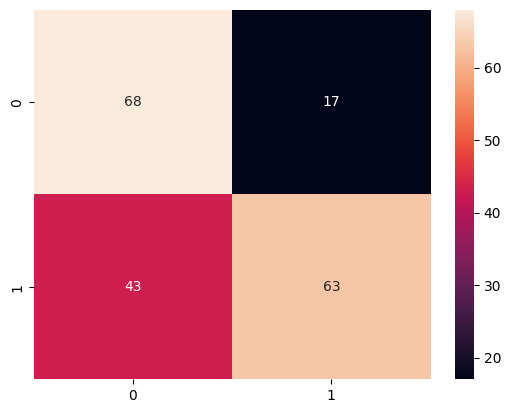

In [97]:
labels=mlp_models['clinical']['confusion']
sns.heatmap(mlp_models['clinical']['confusion'],annot=labels)
plt.show()

In [98]:
conf = mlp_models['gene_expr_reduced']['confusion']
print(recall(conf))
print(f1_score(conf))
print(precision(conf))

0.4
0.4740740740740741
0.5818181818181818


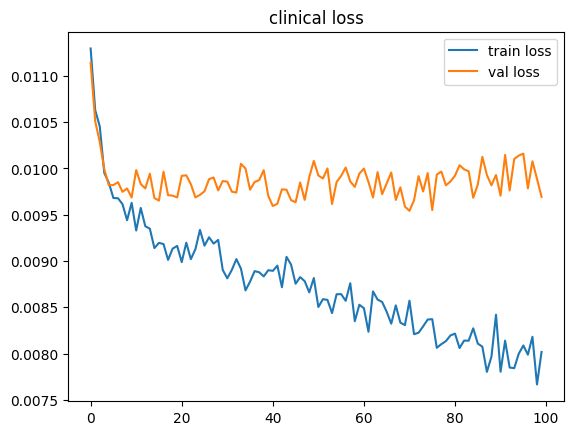

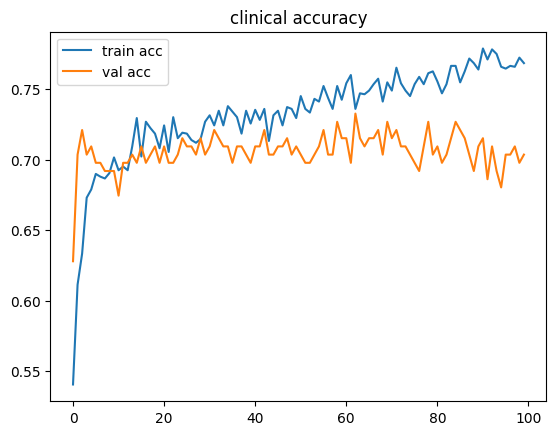

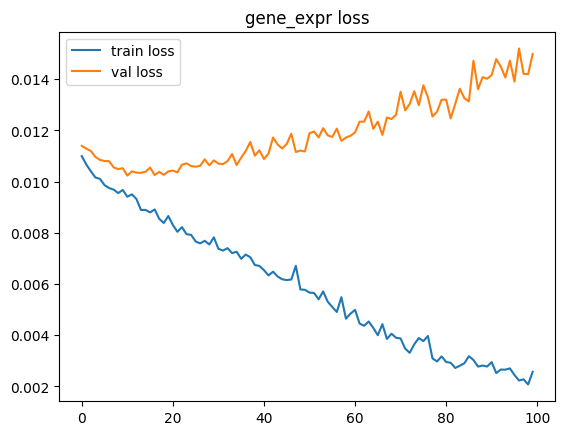

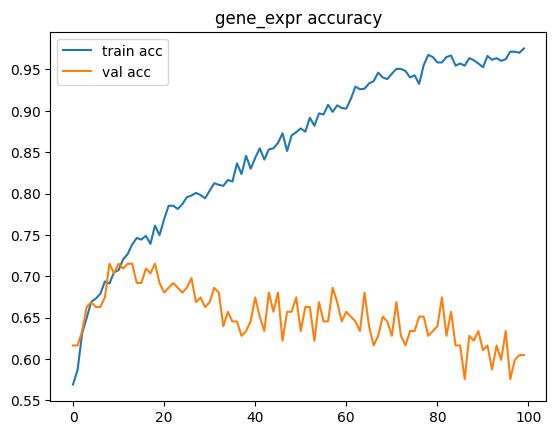

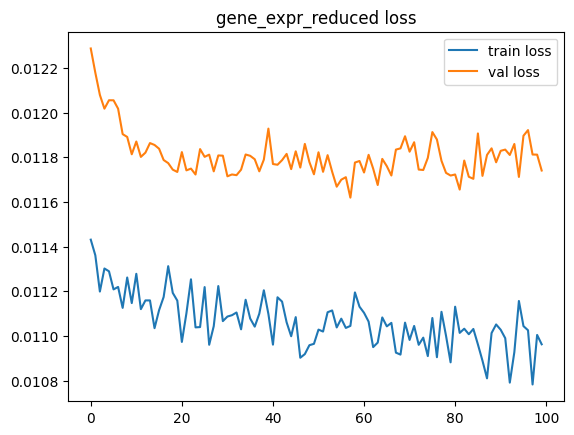

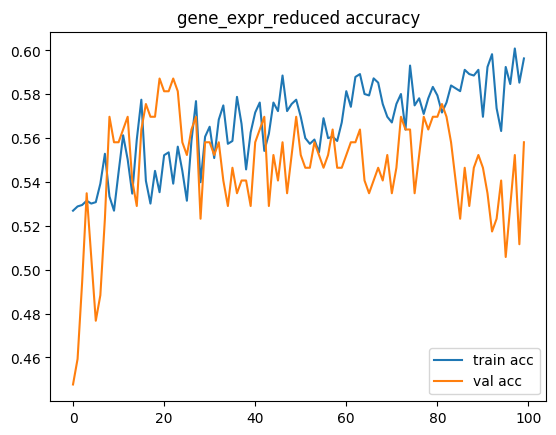

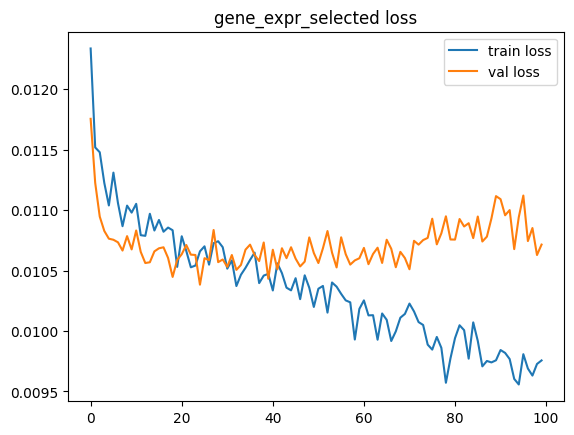

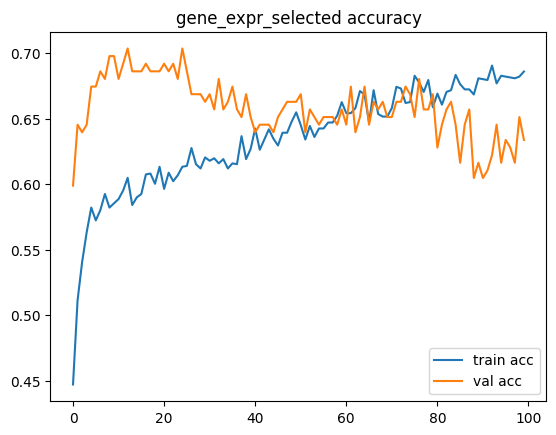

In [99]:
#plot the loss and accuracy curves for all ds_names in mlp_models
for ds_name in mlp_models:
    plt.plot(mlp_models[ds_name]['train_losses'], label='train loss')
    plt.plot(mlp_models[ds_name]['val_losses'], label='val loss')
    plt.title(f'{ds_name} loss')
    plt.legend()
    plt.show()

    plt.plot(mlp_models[ds_name]['train_accs'], label='train acc')
    plt.plot(mlp_models[ds_name]['val_accs'], label='val acc')
    plt.title(f'{ds_name} accuracy')
    plt.legend()
    plt.show()

# Model Comparison (10 Points)

Compare different models and different datasets (clinical, gene expressions, and gene reduced expressions) and try to explain their differences.

#### \# TODO

| Model/Dataset | Clinical   |   Gene Expression | Reduced Gene Expression |
| ----------- | ----------- | ---------------| --------------- |
| Random Forest   |  Best  |  Good  | Good |
| SVM   |    Good  |   Medium    |    Bad   |
| MLP  | Good  |   Best | Best |

Since we previously expected this, random forrest has a better performance on categorial datasets because decision tree does not need to convert features to numeric form to train the model and generally it achieves higher accuracy.
The reason why MLP performs better than the two other models on Gene Expression and Reduced Gene Expression is because MLP models can draw more complex patterns from numeric(floating point) data.
SVM is just a simpler version of MLP so it is expected that MLP performs better than SVM.

All models work better on datasets with features selected using the feature selection process described above than the raw gene expression datasets or that reduced using umap.

We also used Linear Regression as a baseline to find out whether the dimensionality of the data needs reduction.
Generally Linear regression doesn't perform well because it's too simple and the data may not always be linearly separable.


